In [1]:
from google.colab import drive
drive.mount('/content/drive/')
%cd /content/drive/MyDrive/spinal-bone-feature-detection
!ls

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/.shortcut-targets-by-id/1oG2uzFRqi9wz763XVJclWvhPaLhUUFFX/spinal-bone-feature-detection
 best_model_07.pth   config.yaml   GraphScoliosis.ipynb  'YOLOv11 results'
 best_model.pth      datasets	   Untitled0.ipynb


In [2]:
!unzip -q ./datasets/ultrasound.zip -d /tmp/ultrasound
!pip install -q torchmetrics[detection]
# !pip install -q torch_geometric

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 129.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 101.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 60.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 38.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 112.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 62.0 MB/s eta 0:00:00


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.models import resnet18
from torchvision.ops import RoIAlign, box_iou
from torchmetrics.functional.detection.map import mean_average_precision
from torchmetrics.detection.mean_ap import MeanAveragePrecision

import yaml
import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.metrics import precision_recall_curve
from scipy.optimize import linear_sum_assignment
from scipy.interpolate import CubicSpline

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from collections import OrderedDict
from pathlib import Path

# Data Loading

In [20]:
class ScoliosisDataset(Dataset):
    def __init__(self, split='train', config_path='config.yaml'):
        # Initialize the dataset for a given split (train/val)
        with open(config_path, 'r') as f:
            self.config = yaml.safe_load(f)

        self.split = split
        self.processed_images_dir = Path(self.config['data']['processed_images_dir'])
        self.processed_annotations_dir = Path(self.config['data']['processed_annotations_dir'])
        self.metadata_dir = Path(self.config['data']['metadata_dir'])

        # self.global_clusters = {} # Load global cluster assignments
        # with open(self.metadata_dir / "global_clusters.txt", 'r') as f:
        #     for line in f:
        #         image_name, box_idx, cluster_label = line.strip().split()
        #         if image_name not in self.global_clusters:
        #             self.global_clusters[image_name] = []
        #         self.global_clusters[image_name].append((int(box_idx), int(cluster_label)))

        with open(self.metadata_dir / 'splits.yaml', 'r') as f:
            splits = yaml.safe_load(f)

        self.image_names = splits[split]  # List of image names for the split
        self.means = np.array(splits['mean'], dtype=np.float32)  # Shape: (2,)
        self.stds = np.array(splits['std'], dtype=np.float32)    # Shape: (2,)
        self.transforms = self.get_transforms()


    def get_transforms(self):
        speckle_noise_std = self.config['augmentation']['speckle_noise_std']
        elastic_alpha = self.config['augmentation']['elastic_alpha']
        elastic_sigma = self.config['augmentation']['elastic_sigma']
        contrast_range = self.config['augmentation']['contrast_range']
        brightness_range = self.config['augmentation']['brightness_range']

        if self.split == 'train': # Apply augmentation if training
            return A.Compose([
                A.GaussNoise(std_range=(speckle_noise_std, speckle_noise_std), mean_range=(0.0, 0.0), per_channel=True, p=0.5),
                A.ElasticTransform(alpha=elastic_alpha, sigma=elastic_sigma, approximate=False, p=0.5),
                A.RandomBrightnessContrast(brightness_limit=brightness_range, contrast_limit=contrast_range, p=0.5),
                A.Rotate(limit=10, p=0.5), # Small angles to avoid disrupting anatomical structure
                A.Normalize(mean=self.means, std=self.stds, max_pixel_value=1.0, p=1.0), # Ensure pixel values stay in [0, 1]
                ToTensorV2(p=1.0), # Convert to PyTorch tensor
            ], bbox_params=A.BboxParams(
                format='pascal_voc', # [x_min, y_min, x_max, y_max]
                label_fields=['labels', 'clusters'],  # Pass additional labels
                min_area = 1,  # Drop boxes smaller than 1 pixels after augmentation
                min_visibility=0.3  # Discard boxes with less than 30% visibility after augmentation
            ))
        return A.Compose([
            A.Normalize(mean=self.means, std=self.stds, max_pixel_value=1.0, p=1.0), # Only normalization for validation
            ToTensorV2(p=1.0) # Convert to PyTorch tensor
        ])


    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        image_name = self.image_names[idx]
        image = np.load(self.processed_images_dir / f'{image_name}.npy') # Shape: (H, W, 2)

        # Load annotations
        with open(self.processed_annotations_dir / f'{image_name}.txt', 'r') as f:
            annotations = [line.strip().split() for line in f.readlines()]
        annotations = np.array(annotations, dtype=np.float32) # Shape: (num_boxes, 5)

        # Load cluster labels
        # clusters = np.zeros(len(annotations), dtype=np.int64)
        # for box_idx, cluster_label in self.global_clusters[image_name]:
        #     clusters[box_idx] = cluster_label

        # Extract boxes and labels
        boxes = annotations[:, 1:5] # x_min, y_min, x_max, y_max
        labels = annotations[:, 0].astype(np.int64) # 0: Thoracic, 1: Lumbar

        # Apply transformations
        transformed = self.transforms(image=image, bboxes=boxes, labels=labels, clusters=labels)
        image = transformed['image']
        boxes = torch.tensor(transformed['bboxes'], dtype=torch.float32)   # Shape: (num_boxes, 4)
        labels = torch.tensor(transformed['clusters'], dtype=torch.int64)   # Shape: (num_boxes,)
        clusters = torch.tensor(transformed['clusters'], dtype=torch.int64) # Shape: (num_boxes,)
        return image, {'boxes': boxes, 'labels': labels, 'clusters': clusters}

In [21]:
def collate_fn(batch):
    images, targets = zip(*batch)
    images = torch.stack(images, dim=0)  # Shape: (batch_size, 2, H, W)
    return images, list(targets)  # Targets as a list of dictionaries


def get_loader(split='train', config_path='config.yaml', batch_size=32):
    # Create a data loader for a specific split (train/val)
    with open(config_path, 'r') as f:
        config = yaml.safe_load(f)

    dataset = ScoliosisDataset(split=split, config_path=config_path)
    return DataLoader(
        dataset, batch_size=batch_size,
        shuffle=True if split == 'train' else False, num_workers=2,
        pin_memory=True, collate_fn=collate_fn
    )

In [22]:
train_loader, val_loader = get_loader('train', batch_size=32), get_loader('val', batch_size=1)
print(f'Train loader: {len(train_loader.dataset)} samples')
print(f'Val loader: {len(val_loader.dataset)} samples')

for images, targets in train_loader:
    print(f'Batch images shape: {images.shape}')
    for target in targets:
        print(f"boxes={target['boxes'].shape}, "
              f"labels={target['labels'].shape}, "
              f"clusters={target['clusters'].shape}")
    break

Train loader: 42 samples
Val loader: 8 samples
Batch images shape: torch.Size([32, 2, 448, 224])
boxes=torch.Size([26, 4]), labels=torch.Size([26]), clusters=torch.Size([26])
boxes=torch.Size([26, 4]), labels=torch.Size([26]), clusters=torch.Size([26])
boxes=torch.Size([26, 4]), labels=torch.Size([26]), clusters=torch.Size([26])
boxes=torch.Size([26, 4]), labels=torch.Size([26]), clusters=torch.Size([26])
boxes=torch.Size([24, 4]), labels=torch.Size([24]), clusters=torch.Size([24])
boxes=torch.Size([28, 4]), labels=torch.Size([28]), clusters=torch.Size([28])
boxes=torch.Size([26, 4]), labels=torch.Size([26]), clusters=torch.Size([26])
boxes=torch.Size([26, 4]), labels=torch.Size([26]), clusters=torch.Size([26])
boxes=torch.Size([28, 4]), labels=torch.Size([28]), clusters=torch.Size([28])
boxes=torch.Size([28, 4]), labels=torch.Size([28]), clusters=torch.Size([28])
boxes=torch.Size([26, 4]), labels=torch.Size([26]), clusters=torch.Size([26])
boxes=torch.Size([24, 4]), labels=torch.Size(

# Model Components

In [23]:
class GNN(nn.Module):
    def __init__(self, in_features, edge_features, out_feature, device, ratio=(1,)):
        super(GNN, self).__init__()
        self.edge_net = EdgeNet(in_features=in_features, num_features=edge_features, device=device, ratio=ratio)
        self.node_net = NodeNet(in_features=in_features, num_features=out_feature, device=device, ratio=ratio) # Set edge to node
        self.mask_val = -1 # mask value for no-gradient edges

    def label2edge(self, targets): # Convert node labels to affinity mask for backprop
        num_sample = targets.size()[1]
        label_i = targets.unsqueeze(-1).repeat(1, 1, num_sample)
        label_j = label_i.transpose(1, 2)
        edge = torch.eq(label_i, label_j).float()
        target_edge_mask = (torch.eq(label_i, self.mask_val) + torch.eq(label_j, self.mask_val)).type(torch.bool)
        source_edge_mask = ~target_edge_mask
        edge *= source_edge_mask.float()
        return edge[0], source_edge_mask

    def forward(self, node_feat):
        edge_feat, edge_sim = self.edge_net(node_feat) # Compute normalized and not normalized affinity matrix
        logits_gnn = self.node_net(node_feat, edge_feat) # Get edge feature and class logits
        return logits_gnn, edge_sim


class EdgeNet(nn.Module):
    def __init__(self, in_features, num_features, device, ratio=(1,)):
        super(EdgeNet, self).__init__()
        num_features_list = [num_features * r for r in ratio]
        layer_list = OrderedDict()
        self.device = device

        for l in range(len(num_features_list)):
            layer_list['conv%d' % l] = nn.Conv2d(
                in_channels = num_features_list[l - 1] if l > 0 else in_features,
                out_channels = num_features_list[l],
                kernel_size = 1, bias = False
            )
            layer_list['norm%d' % l] = nn.BatchNorm2d(num_features=num_features_list[l])
            layer_list['relu%d' % l] = nn.LeakyReLU()

        # Add final similarity kernel
        layer_list['conv_out'] = nn.Conv2d(in_channels=num_features_list[-1], out_channels=1, kernel_size=1)
        self.sim_network = nn.Sequential(layer_list).to(device)


    def forward(self, node_feat):
        node_feat = node_feat.unsqueeze(dim=0) # (1, bs, dim)
        num_tasks = node_feat.size(0) # 1
        num_data = node_feat.size(1) # bs

        x_i = node_feat.unsqueeze (2) # (1, bs, 1, dim)
        x_j = torch.transpose(x_i, 1, 2) # (1, 1, bs, dim)
        x_ij = torch.abs(x_i - x_j) # (1, bs, bs, dim)
        x_ij = torch.transpose(x_ij, 1, 3) # (1, dim, bs, bs)

        # Compute similarity / dissimilarity (batch_size x feat_size x num_samples x num_samples)
        sim_val = (torch.sigmoid(self.sim_network(x_ij)).squeeze(1).squeeze(0).to(self.device)) # (bs, bs)

        # Normalize affinity matrix
        force_edge_feat = (torch.eye(num_data).unsqueeze(0).repeat(num_tasks, 1, 1).to(self.device)) # (1, bs, bs)
        edge_feat = sim_val + force_edge_feat # (bs, bs)
        edge_feat = edge_feat + 1e-6 # Add small value to avoid nan
        edge_feat = edge_feat / torch.sum( edge_feat, dim =1).unsqueeze (1) # Normalize
        return edge_feat, sim_val # (bs, bs), (bs, bs)


class NodeNet(nn.Module):
    def __init__(self, in_features, num_features, device, ratio =(1,)):
        super(NodeNet, self).__init__()
        num_features_list = [num_features * r for r in ratio]
        layer_list = OrderedDict()
        self.device = device

        for l in range(len(num_features_list)):
            layer_list['conv%d' % l] = nn.Conv2d(
                in_channels = num_features_list[l - 1] if l > 0 else in_features * 2,
                out_channels = num_features_list[l],
                kernel_size = 1,
                bias = False,
            )
            layer_list['norm%d' % l] = nn.BatchNorm2d(num_features=num_features_list[l])

            if l < len(num_features_list) - 1: layer_list['relu%d' % l] = nn.LeakyReLU()
        self.network = nn.Sequential(layer_list).to(device)


    def forward(self, node_feat, edge_feat):
        # node_feat: (bs, dim), edge_feat: (bs, bs)
        node_feat = node_feat.unsqueeze(dim=0) # (1, bs, dim)
        num_tasks = node_feat.size(0) # 1
        num_data = node_feat.size(1) # bs

        # Get eye matrix(batch_size x node_size x node_size) only use inter dist.
        diag_mask = 1.0 - torch.eye(num_data).unsqueeze(0).repeat(num_tasks, 1, 1).to(self.device) # (1, bs, bs)

        # Set diagonal as zero and normalize
        edge_feat = F.normalize(edge_feat * diag_mask, p=1, dim=-1) # (bs, bs)

        # Compute attention and aggregate
        aggr_feat = torch.bmm(edge_feat.squeeze(1), node_feat) # (bs, dim)
        node_feat = torch.cat([node_feat, aggr_feat], -1).transpose(1, 2) # (1, 2 * dim, bs)

        # Non-linear transform
        node_feat = self.network(node_feat.unsqueeze(-1)).transpose(1, 2) # (1, bs, dim)
        return node_feat.squeeze(-1).squeeze(0) # (bs, dim)

In [24]:
class MultiTaskModel(nn.Module):
    def __init__(self, num_classes=2):
        super(MultiTaskModel, self).__init__()
        self.backbone = nn.Sequential(*list(resnet18().children())[:-2])  # Remove avgpool and fc layers
        self.backbone[0] = nn.Conv2d(in_channels=2, out_channels=64, kernel_size=7, stride=2, padding=3, bias=False)
        self.backbone2roi_proj = nn.Conv2d(in_channels=512, out_channels=64, kernel_size=1)

        self.roi_align = RoIAlign(output_size=(5, 5), spatial_scale=1.0 / 32.0, sampling_ratio=-1)
        self.gnn = GNN(in_features=64 * 5 * 5, edge_features=512, out_feature=num_classes + 1, device='cuda', ratio=(1,)) # + 1 for background
        self.box_regressor = nn.Sequential(
            nn.Linear(64 * 5 * 5, 256),
            nn.ReLU(),
            nn.Linear(256, 4)
        )

    def forward(self, images, all_boxes, boxes_by_images):
        feature_maps = self.backbone(images) # Shape: (batch_size, 512, H/32, W/32)
        feature_maps = self.backbone2roi_proj(feature_maps) # Shape: (batch_size, 64, H/32, W/32)

        # Create batch indices for each box
        batch_indices = torch.cat([
            torch.full((len(b),), i, dtype=torch.int64)
            for i, b in enumerate(boxes_by_images)
        ], dim=0).to(images.device) # Shape: (total_boxes,)

        # Combine batch_indices and all_boxes into a single rois tensor
        rois = torch.cat([batch_indices.unsqueeze(1).float(), all_boxes], dim=1) # Shape: (total_boxes, 5)

        # Apply RoIAlign and flatten the pooled features
        pooled_features = self.roi_align(feature_maps, rois) # Shape: (total_boxes, 64, 5, 5)
        pooled_features = pooled_features.view(pooled_features.size(0), -1)  # Shape: (total_boxes, 64 * 5 * 5)

        pred_boxes = self.box_regressor(pooled_features)
        pred_labels, edge_sim = self.gnn(pooled_features)
        return pred_boxes, pred_labels, edge_sim

# Training Utilities

In [9]:
from torchvision.ops import complete_box_iou_loss, distance_box_iou_loss, generalized_box_iou_loss

In [29]:
def compute_losses(images, targets, criterion_box, criterion_cls, criterion_edge, device):
    images = images.to(device)
    boxes_by_images, all_labels, all_clusters = [], [], []
    for target in targets:
        boxes_by_images.append(target['boxes'].to(device))
        all_labels.append(target['labels'].to(device))
        all_clusters.append(target['clusters'].to(device))

    all_boxes = torch.cat(boxes_by_images, dim=0)
    all_labels = torch.cat(all_labels, dim=0)
    all_clusters = torch.cat(all_clusters, dim=0)
    pred_boxes, pred_labels, edge_sim = model(images, all_boxes, boxes_by_images)

    # Calculate Multi-task loss
    box_loss = criterion_box(pred_boxes, all_boxes, reduction='mean') # Box loss
    cls_loss = criterion_cls(pred_labels, all_labels) # Cls loss

    edge_gt, edge_mask = model.gnn.label2edge(all_labels.unsqueeze(dim=0))
    edge_loss = criterion_edge( # Edge loss
        edge_sim.masked_select(edge_mask), edge_gt.masked_select(edge_mask)
    )
    return cls_loss, box_loss, edge_loss, all_boxes, all_labels, pred_boxes, pred_labels

In [30]:
def train_model(model, train_loader, val_loader, optimizer, num_epochs, device):
    # Train a multi-task model for object detection and clustering
    train_total_losses, train_cls_losses, train_box_losses, train_edge_losses = [], [], [], []
    val_total_losses, val_cls_losses, val_box_losses, val_edge_losses, best_val_total_loss = [], [], [], [], torch.inf
    criterion_box, criterion_cls, criterion_edge = complete_box_iou_loss, nn.CrossEntropyLoss(), nn.BCELoss()

    # scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.6, patience=10, threshold=0.01, min_lr=2e-5)
    for epoch in range(num_epochs): # Training loop
        # loop = tqdm(enumerate(train_loader), total=total_batches)
        train_total_loss, train_cls_loss, train_box_loss, train_edge_loss = 0, 0, 0, 0
        # mAP_preds, mAP_targets = [], []
        total_batches = len(train_loader)
        model.train()

        # Iterate over training batches
        for batch_idx, (images, targets) in enumerate(train_loader):
            cls_loss, box_loss, edge_loss, all_boxes, all_labels, pred_boxes, pred_labels = \
            compute_losses(images, targets, criterion_box, criterion_cls, criterion_edge, device)

            # Aggregate losses
            total_loss = cls_loss + box_loss + edge_loss
            train_cls_loss += cls_loss.item()
            train_box_loss += box_loss.item()
            train_edge_loss += edge_loss.item()
            train_total_loss += total_loss.item()

            # Prepare for mAP calculation
            # pred_labels = F.softmax(pred_labels, dim=-1)
            # scores, pred_labels_idxs = pred_labels.max(dim=1)
            # mAP_preds.append({"boxes": pred_boxes, "scores": scores, "labels": pred_labels_idxs})
            # mAP_targets.append({"boxes": all_boxes, "labels": all_labels})

            # Backward pass and optimization
            optimizer.zero_grad() # Zero gradients
            total_loss.backward()
            optimizer.step()

            # Update the progress bar
            # loop.set_description(f"[EPOCH {epoch+1}/{num_epochs}] {batch_idx + 1}/{total_batches}")
            # loop.set_postfix(loss=total_loss.item(), accuracy=(correct / total).item())

        train_cls_loss = train_cls_loss / total_batches
        train_box_loss = train_box_loss / total_batches
        train_edge_loss = train_edge_loss / total_batches
        train_total_loss = train_total_loss / total_batches
        # train_mAPs = mean_average_precision(mAP_preds, mAP_targets, class_metrics=True)

        train_cls_losses.append(train_cls_loss)
        train_box_losses.append(train_box_loss)
        train_edge_losses.append(train_edge_loss)
        train_total_losses.append(train_total_loss)

        # Validation
        val_total_loss, val_cls_loss, val_box_loss, val_edge_loss, val_mAPs = evaluate_model(model, val_loader, device)
        val_total_losses.append(val_total_loss)
        val_cls_losses.append(val_cls_loss)
        val_box_losses.append(val_box_loss)
        val_edge_losses.append(val_edge_loss)

        # Print all the results
        print(
            f"[EPOCH {epoch+1}/{num_epochs}] "
            f"Train Loss: {train_total_loss:.4f} (CLS: {train_cls_loss:.4f}, BOX: {train_box_loss:.4f}, EDGE: {train_edge_loss:.4f})"
            # f" - Train mAP@0.5: {train_mAPs['map_50']:.4f}"
            f" - Val Loss: {val_total_loss:.4f} (CLS: {val_cls_loss:.4f}, BOX: {val_box_loss:.4f}, EDGE: {val_edge_loss:.4f})"
            # f" - Val mAP@0.5: {val_mAPs['map_50']:.4f}"
            # f" - LR: {scheduler.get_last_lr()[0]:.6f}"
        )

        # Save the best model based on validation loss
        if val_total_loss < best_val_total_loss:
            best_val_total_loss = val_total_loss
            torch.save(model.state_dict(), "best_model.pth")
        # scheduler.step(val_total_loss)


def evaluate_model(model, val_loader, device):
    criterion_box, criterion_cls, criterion_edge = complete_box_iou_loss, nn.CrossEntropyLoss(), nn.BCELoss()
    val_total_loss, val_cls_loss, val_box_loss, val_edge_loss = 0, 0, 0, 0
    # mAP_preds, mAP_targets = [], []
    total_batches = len(val_loader)
    model.eval()

    with torch.no_grad():
        for images, targets in val_loader:
            cls_loss, box_loss, edge_loss, all_boxes, all_labels, pred_boxes, pred_labels = \
            compute_losses(images, targets, criterion_box, criterion_cls, criterion_edge, device)

            # Aggregate losses
            total_loss = cls_loss + box_loss + edge_loss
            val_cls_loss += cls_loss.item()
            val_box_loss += box_loss.item()
            val_edge_loss += edge_loss.item()
            val_total_loss += total_loss.item()

            # Prepare for mAP calculation
            # pred_labels = F.softmax(pred_labels, dim=-1)
            # scores, pred_labels_idxs = pred_labels.max(dim=1)
            # mAP_preds.append({"boxes": pred_boxes, "scores": scores, "labels": pred_labels_idxs})
            # mAP_targets.append({"boxes": all_boxes, "labels": all_labels})

    val_cls_loss = val_cls_loss / total_batches
    val_box_loss = val_box_loss / total_batches
    val_edge_loss = val_edge_loss / total_batches
    val_total_loss = val_total_loss / total_batches
    mAPs = {} # mean_average_precision(mAP_preds, mAP_targets, class_metrics=True)
    return val_total_loss, val_cls_loss, val_box_loss, val_edge_loss, mAPs

# Model Experiment

In [31]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_loader, val_loader = get_loader('train', batch_size=32), get_loader('val', batch_size=1)
model = MultiTaskModel().to(device)
optimizer = optim.AdamW(model.parameters(), lr=2e-4)

In [32]:
%%time
import gc
gc.collect()
torch.cuda.empty_cache()
train_model(model, train_loader, val_loader, optimizer, num_epochs=1000, device=device)

[EPOCH 1/1000] Train Loss: 3.8770 (CLS: 1.1531, BOX: 1.9395, EDGE: 0.7845) - Val Loss: 7.4031 (CLS: 4.8956, BOX: 1.8063, EDGE: 0.7012)
[EPOCH 2/1000] Train Loss: 3.3092 (CLS: 0.7983, BOX: 1.8251, EDGE: 0.6858) - Val Loss: 7.9966 (CLS: 3.8753, BOX: 3.1081, EDGE: 1.0131)
[EPOCH 3/1000] Train Loss: 3.3533 (CLS: 0.7262, BOX: 2.0569, EDGE: 0.5703) - Val Loss: 5.6215 (CLS: 1.9973, BOX: 2.9225, EDGE: 0.7017)
[EPOCH 4/1000] Train Loss: 3.4810 (CLS: 0.6704, BOX: 2.4578, EDGE: 0.3528) - Val Loss: 4.2925 (CLS: 1.1669, BOX: 2.5569, EDGE: 0.5687)
[EPOCH 5/1000] Train Loss: 3.5782 (CLS: 0.6564, BOX: 2.6876, EDGE: 0.2342) - Val Loss: 3.4618 (CLS: 0.8254, BOX: 2.1450, EDGE: 0.4914)
[EPOCH 6/1000] Train Loss: 3.1994 (CLS: 0.6301, BOX: 2.4038, EDGE: 0.1655) - Val Loss: 2.9625 (CLS: 0.6749, BOX: 1.8970, EDGE: 0.3906)
[EPOCH 7/1000] Train Loss: 2.7605 (CLS: 0.6080, BOX: 2.0301, EDGE: 0.1224) - Val Loss: 2.7168 (CLS: 0.6078, BOX: 1.8130, EDGE: 0.2960)
[EPOCH 8/1000] Train Loss: 2.5702 (CLS: 0.6000, BOX: 1.

# Evaluation

{'map': tensor(0.3864),
 'map_50': tensor(0.8505),
 'map_75': tensor(0.3333),
 'map_small': tensor(0.3570),
 'map_medium': tensor(0.4106),
 'map_large': tensor(-1.),
 'mar_1': tensor(0.0556),
 'mar_10': tensor(0.3640),
 'mar_100': tensor(0.5124),
 'mar_small': tensor(0.4922),
 'mar_medium': tensor(0.5397),
 'mar_large': tensor(-1.),
 'map_per_class': tensor([0.3851, 0.3877]),
 'mar_100_per_class': tensor([0.5226, 0.5021]),
 'classes': tensor([0, 1], dtype=torch.int32)}

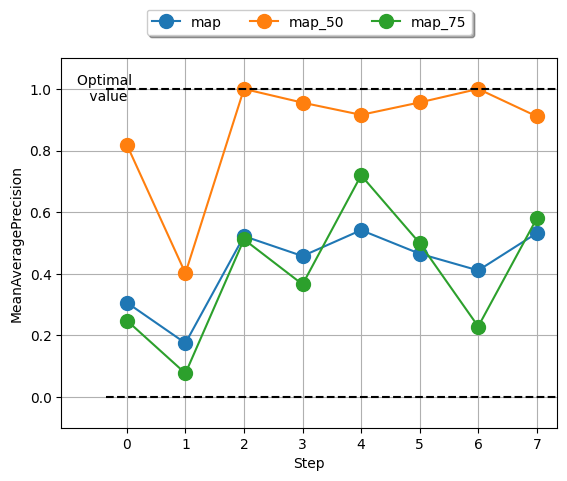

In [33]:
checkpoint = torch.load('best_model.pth')
model.load_state_dict(checkpoint)
model.eval()

with torch.no_grad():
    metric = MeanAveragePrecision(class_metrics=True)
    mAP_by_step, mAP_preds, mAP_targets, pred_labels_probs = [], [], [], []

    for images, targets in val_loader:
        images = images.to(device)
        boxes_by_images, all_labels, all_clusters = [], [], []
        for target in targets:
            boxes_by_images.append(target['boxes'].to(device))
            all_labels.append(target['labels'].to(device))
            all_clusters.append(target['clusters'].to(device))

        all_boxes = torch.cat(boxes_by_images, dim=0)
        all_labels = torch.cat(all_labels, dim=0)
        all_clusters = torch.cat(all_clusters, dim=0)
        pred_boxes, pred_labels, _ = model(images, all_boxes, boxes_by_images)
        pred_labels = F.softmax(pred_labels, dim=-1)
        scores, pred_labels_idxs = pred_labels.max(dim=1)

        pred_labels_probs.append(pred_labels)
        mAP_preds.append({"boxes": pred_boxes, "scores": scores, "labels": pred_labels_idxs})
        mAP_targets.append({"boxes": all_boxes, "labels": all_labels})
        mAP_dict = metric([mAP_preds[-1]], [mAP_targets[-1]])

        # Remove keys started with mar or with classes
        mAP_dict = {k: v for k, v in mAP_dict.items() if k in ['map', 'map_50', 'map_75']}
        mAP_by_step.append(mAP_dict)

metric.plot(mAP_by_step)
{k: v for k, v in mean_average_precision(mAP_preds, mAP_targets, class_metrics=True).items()}

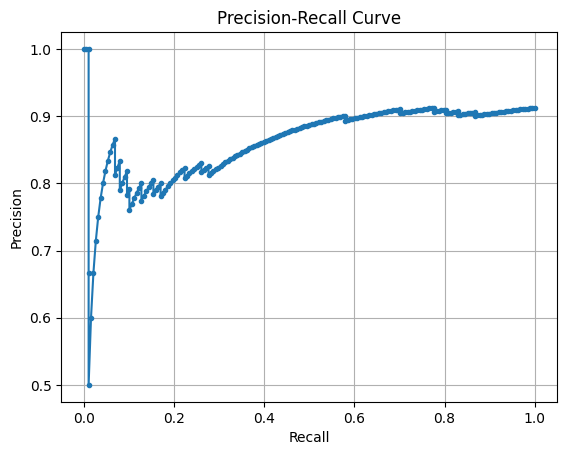

In [34]:
# Function to evaluate predictions and compute PR curve
def compute_pr_curve(preds, targets, iou_threshold=0.5):
    all_scores = []
    all_labels = [] # 1 for TP, 0 for FP

    for pred, target in zip(preds, targets):
        pred_boxes = pred["boxes"]  # [N, 4]
        scores = pred["scores"]     # [N]
        pred_labels = pred["labels"] # [N]
        gt_boxes = target["boxes"]  # [M, 4]
        gt_labels = target["labels"] # [M]
        if len(pred_boxes) == 0 or len(gt_boxes) == 0: continue

        # Compute IoU between all pred and gt boxes
        iou = box_iou(pred_boxes, gt_boxes).cpu().numpy()  # [N, M]
        max_iou = np.max(iou, axis=1)  # Best IoU for each prediction
        matched_idx = np.argmax(iou, axis=1)

        # For each prediction, determine if it's a TP or FP
        for i, (score, pred_label) in enumerate(zip(scores, pred_labels)):
            if max_iou[i] >= iou_threshold:
                gt_idx = matched_idx[i]
                if pred_label == gt_labels[gt_idx]: all_labels.append(1)  # True Positive
                else: all_labels.append(0)  # False Positive (wrong label)
            else: all_labels.append(0)  # False Positive (no match)
            all_scores.append(score.cpu().numpy())

    # Sort by scores in descending order
    all_scores = np.array(all_scores)
    all_labels = np.array(all_labels)
    order = np.argsort(all_scores)[::-1]
    all_scores = all_scores[order]
    all_labels = all_labels[order]

    # Compute precision and recall
    precision, recall, _ = precision_recall_curve(all_labels, all_scores)
    return precision, recall

precision, recall = compute_pr_curve(mAP_preds, mAP_targets)
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.show()

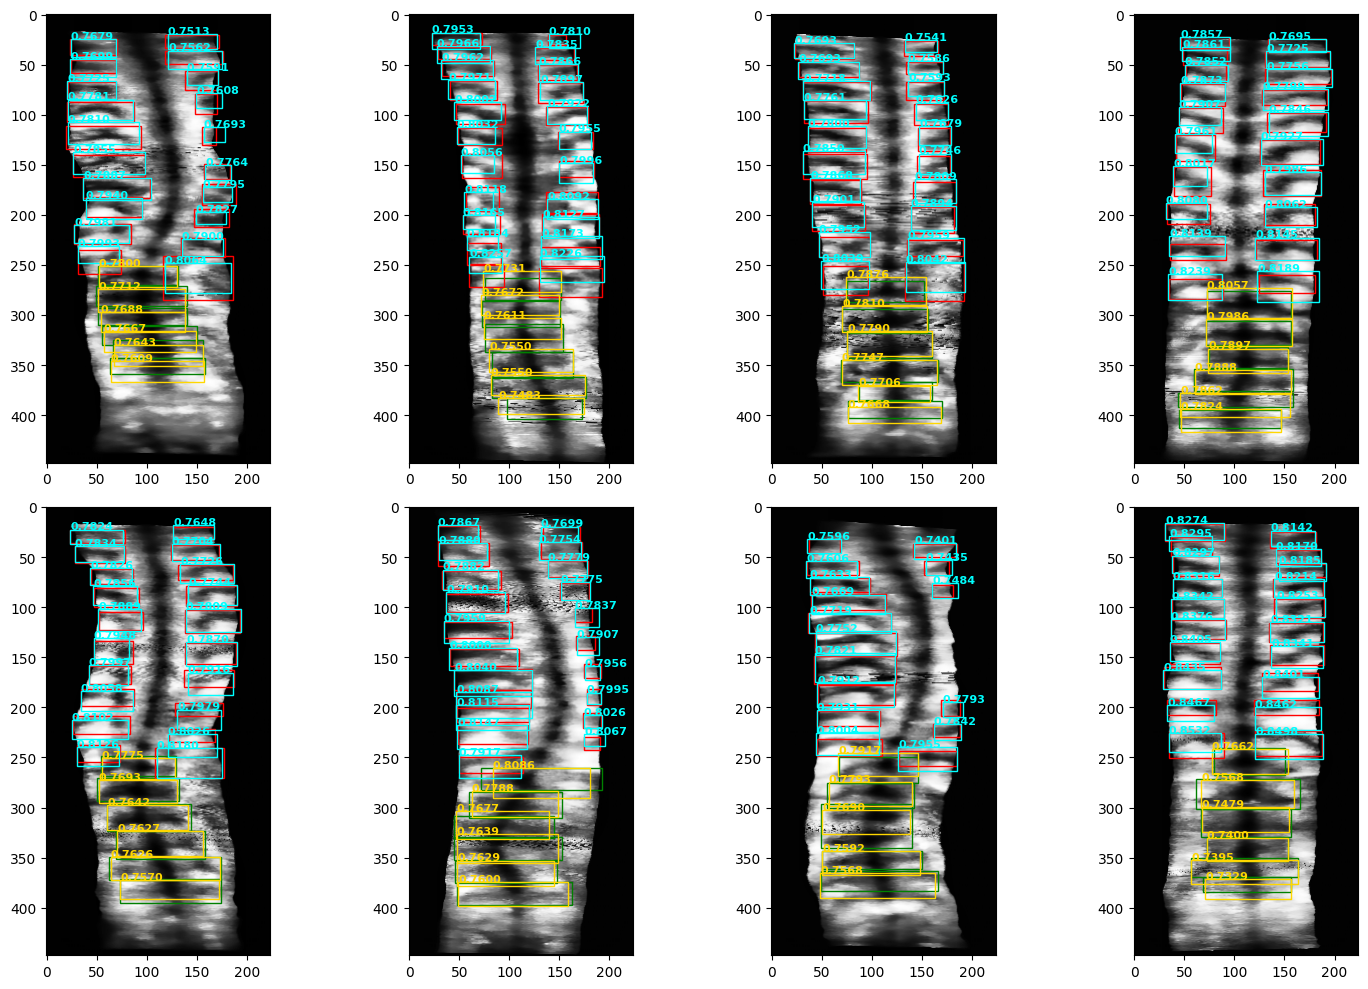

In [35]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(15, 10)) # Create a 2x4 subplot grid
axes = axes.flatten()  # Flatten the grid for easy indexing
grid_idx, pred_prid_idx = 0, 0 # Counter for the grid positions
model.eval()

for images, targets in val_loader:
    images = images.to(device)
    boxes_by_images, labels_by_images, all_labels, all_clusters = [], [], [], []

    for target in targets:
        boxes_by_images.append(target['boxes'].to(device))
        labels_by_images.append(target['labels'].to(device))
        all_clusters.append(target['clusters'].to(device))

    all_boxes = torch.cat(boxes_by_images, dim=0)
    all_labels = torch.cat(labels_by_images, dim=0)
    all_clusters = torch.cat(all_clusters, dim=0)
    pred_boxes, pred_labels, _ = model(images, all_boxes, boxes_by_images)
    pred_labels = F.softmax(pred_labels, dim=-1)
    scores, pred_labels_idxs = pred_labels.max(dim=1)

    # Reshape to match boxes_by_images shape
    pred_boxes_by_images = torch.split(pred_boxes, [len(b) for b in boxes_by_images])
    pred_labels_by_images = torch.split(pred_labels_idxs, [len(b) for b in boxes_by_images])
    scores_by_images = torch.split(scores, [len(b) for b in boxes_by_images])

    # Plot each ground truth box
    for image, boxes, labels in zip(images, boxes_by_images, labels_by_images):
        if grid_idx >= len(axes): break # Stop if all subplots are filled
        axes[grid_idx].imshow(image[0, :].cpu().numpy(), cmap='gray')
        grid_idx += 1  # Move to the next subplot position

        for box, label in zip(boxes, labels):
            if label >= 2: continue
            x1, y1, x2, y2 = box.cpu().numpy()
            color = 'red' if label == 0 else 'green'
            rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=1, edgecolor=color, facecolor='none')
            axes[grid_idx - 1].add_patch(rect) # Add the rectangle to the plot


    # Plot each predicted box (Similar processing as for ground truth boxes)
    for image, boxes, labels, scores in zip(images, pred_boxes_by_images, pred_labels_by_images, scores_by_images):
        if pred_prid_idx >= len(axes): break # Stop if all subplots are filled
        pred_prid_idx += 1  # Move to the next subplot position

        for box, label, score in zip(boxes, labels, scores):
            if label >= 2: continue
            x1, y1, x2, y2 = box.cpu().detach().numpy() # Detach the tensor before converting to NumPy
            color = 'aqua' if label == 0 else 'gold'
            rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=1, edgecolor=color, facecolor='none')
            axes[pred_prid_idx - 1].add_patch(rect) # Add the rectangle to the plot
            axes[pred_prid_idx - 1].text(
                x1, y1, f'{score.cpu().detach().numpy():.4f}',
                fontsize=8, fontweight='bold',
                color=color, # bbox=dict(facecolor='white', alpha=0.2)
            )
    if grid_idx >= len(axes): break # Stop if all subplots are filled

for ax in axes[grid_idx:]: ax.axis('off') # Hide any unused subplots
plt.tight_layout()
plt.show()